In [47]:
import pandas as pd
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, GRU
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from keras_tuner import RandomSearch
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

In [48]:
# za 1 razem pobrac
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [49]:
df = pd.read_csv('training.csv', header=None, names=['sentiment', 'id', 'date', 'query', 'user', 'text'], encoding='ISO-8859-1')
df = df.drop(columns=['query', 'id', 'user', 'date'])

/var/folders/13/vypvgv0x0n13zkc7gg4wg7hr0000gn/T/ipykernel_4200/1493389583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


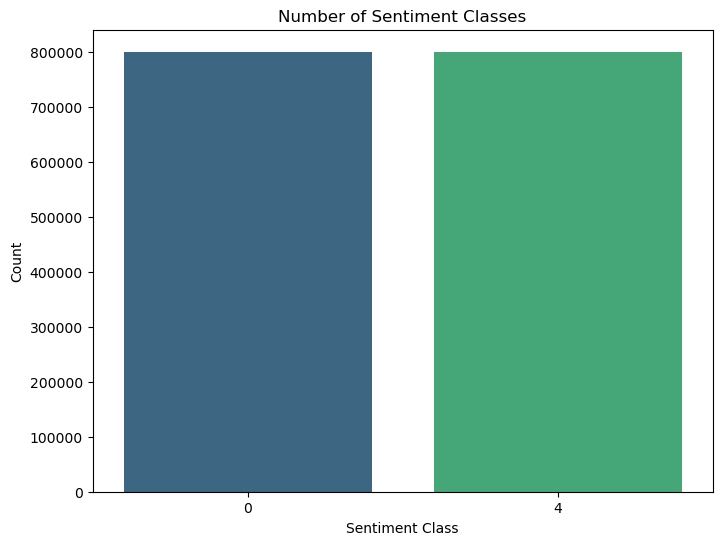

In [50]:
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Number of Sentiment Classes")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()

In [51]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [52]:
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [53]:
def count_hashtags(text):
    return len(re.findall(r'#', text))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove numbers (optional: uncomment if needed)
    # text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Reconstruct the text
    return ' '.join(tokens)

df['hashtag_count'] = df['text'].apply(count_hashtags)

In [54]:
df['cleaned_text'] = df['text'].apply(clean_text)
df

,sentiment,text,hashtag_count,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,0,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,0,dived many time ball managed save 50 rest go b...
3,0,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",0,behaving im mad cant see
...,...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,0,woke school best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,0,thewdbcom cool hear old walt interview â
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,0,ready mojo makeover ask detail
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,0,happy 38th birthday boo alll time tupac amaru ...


In [55]:
num_words=10000
max_length = 20

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

y_binary = [1 if label == 4 else 0 for label in df['sentiment']]

In [56]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Ensure y_true is cast to float
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.cast(y_true, K.floatx())  # Ensure y_true is cast to float
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [57]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_binary, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)

embedding_dim = 128

# Budowa modelu LSTM
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32
)

results = model.evaluate(X_val, y_val)
print("Loss, Accuracy:", results)

model.save("models/lstm_sentiment_binary_model.h5")

40000/40000 ━━━━━━━━━━━━━━━━━━━━ 670s 17ms/step - accuracy: 0.7860 - f1_m: 15.6914 - loss: 0.4530 - precision_m: 15.9369 - recall_m: 15.7380 - val_accuracy: 0.8167 - val_f1_m: 15.6549 - val_loss: 0.4002 - val_precision_m: 16.0506 - val_recall_m: 15.4611
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.8166 - f1_m: 15.6387 - loss: 0.4001 - precision_m: 16.0262 - recall_m: 15.4477


Loss, Accuracy: [0.40018314123153687, 0.8166593909263611, 15.654923439025879, 16.050600051879883, 15.461099624633789]


In [58]:
X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

In [59]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=hp.Choice('embedding_dim', [64, 128, 256])),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_lstm',
    project_name='lstm_tuning'
)
# Dane wejściowe do Random Search
tuner.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])
)

# Najlepsze hiperparametry
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Najlepsze hiperparametry:")
print(f"Liczba jednostek LSTM: {best_hps.get('lstm_units')}")
print(f"Współczynnik dropout: {best_hps.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps.get('dense_units')}")
# print(f"Learning rate: {best_hps.get('learning_rate')}")


Reloading Tuner from random_search_lstm/lstm_tuning/tuner0.json
Najlepsze hiperparametry:
Liczba jednostek LSTM: 32
Współczynnik dropout: 0.2
Liczba jednostek Dense: 80


In [60]:
# Budowa modelu CNN
model = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5), 
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

# Trenowanie modelu
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=32
)

# Ewaluacja modelu
results = model.evaluate(X_val, y_val)
print("Loss, Accuracy:", results)

# Zapis modelu
model.save("models/cnn_sentiment_binary_model.h5")


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 327s 8ms/step - accuracy: 0.7775 - f1_m: 15.6420 - loss: 0.4652 - precision_m: 15.9998 - recall_m: 15.5870 - val_accuracy: 0.8097 - val_f1_m: 15.7564 - val_loss: 0.4168 - val_precision_m: 16.0506 - val_recall_m: 15.6621
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8103 - f1_m: 15.7579 - loss: 0.4160 - precision_m: 16.0262 - recall_m: 15.6837


Loss, Accuracy: [0.4167647063732147, 0.8096906542778015, 15.756443977355957, 16.050600051879883, 15.662099838256836]


In [61]:
# Funkcja budowy modelu CNN
def build_cnn_model(hp):
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=hp.Choice('embedding_dim', [64, 128, 256])),
        Conv1D(
            filters=hp.Int('filters', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
            activation='relu'
        ),
        GlobalMaxPooling1D(),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner_cnn = RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning'
)

# Dane wejściowe do Random Search
tuner_cnn.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])
)

# Najlepsze hiperparametry
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

print(f"Najlepsze hiperparametry:")
print(f"Liczba filtrów: {best_hps_cnn.get('filters')}")
print(f"Rozmiar kernela: {best_hps_cnn.get('kernel_size')}")
print(f"Współczynnik dropout: {best_hps_cnn.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_cnn.get('dense_units')}")
#print(f"Batch size: {best_hps_cnn.get('batch_size')}")
#print(f"Learning rate: {best_hps.get('learning_rate')}")




Reloading Tuner from random_search_cnn/cnn_tuning/tuner0.json
Najlepsze hiperparametry:
Liczba filtrów: 192
Rozmiar kernela: 3
Współczynnik dropout: 0.4
Liczba jednostek Dense: 112


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Budowa modelu GRU
model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=embedding_dim),  # Warstwa osadzeń
    GRU(128, return_sequences=False),  # Warstwa GRU, 128 jednostek
    Dropout(0.5),  # Regularizacja
    Dense(32, activation='relu'),  # Warstwa ukryta
    Dense(1, activation='sigmoid')  # Warstwa wyjściowa
])

# Kompilacja modelu
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

# Trenowanie modelu
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,  # Liczba epok
    batch_size=32  # Rozmiar wsadu
)

# Ewaluacja modelu
results_gru = model_gru.evaluate(X_val, y_val)
print("Loss, Accuracy:", results_gru)

# Zapis modelu
model_gru.save("models/gru_sentiment_binary_model.h5")


40000/40000 ━━━━━━━━━━━━━━━━━━━━ 956s 24ms/step - accuracy: 0.7807 - f1_m: 15.7833 - loss: 0.4531 - precision_m: 15.9718 - recall_m: 16.0133 - val_accuracy: 0.8167 - val_f1_m: 15.5264 - val_loss: 0.4014 - val_precision_m: 16.0506 - val_recall_m: 15.2146
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8163 - f1_m: 15.5212 - loss: 0.4008 - precision_m: 16.0262 - recall_m: 15.2237


Loss, Accuracy: [0.40138351917266846, 0.8166687488555908, 15.526445388793945, 16.050600051879883, 15.214599609375]


In [63]:
def build_gru_model(hp):
    model = Sequential([
        Embedding(
            input_dim=num_words, 
            output_dim=hp.Choice('embedding_dim', [64, 128, 256])  # Testowane wymiary osadzeń
        ),
        GRU(
            units=hp.Int('gru_units', min_value=64, max_value=256, step=64),  # Liczba jednostek GRU
            return_sequences=False
        ),
        Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),  # Współczynnik Dropout
        Dense(
            units=hp.Int('dense_units', min_value=16, max_value=128, step=16), 
            activation='relu'
        ),
        Dense(1, activation='sigmoid')  # Warstwa wyjściowa
    ])
    model.compile(
        optimizer='adam',  # Testowane learning rates
        loss='binary_crossentropy',
        metrics=['accuracy', f1_m, precision_m, recall_m]
    )
    return model

# Random Search
tuner_gru = RandomSearch(
    build_gru_model,
    objective='val_accuracy',  # Cel optymalizacji
    max_trials=10,  # Liczba prób Random Search
    executions_per_trial=1,  # Liczba wykonania na próbę
    directory='random_search_gru',
    project_name='gru_tuning'
)

# Przeprowadzenie wyszukiwania
tuner_gru.search(
    X_train_subset, y_train_subset,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=tuner.oracle.hyperparameters.Choice('batch_size', [16, 32, 64])  # Testowane rozmiary wsadów
)

# Pobranie najlepszych hiperparametrów
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"Najlepsze hiperparametry:")
print(f"Wymiary osadzeń: {best_hps_gru.get('embedding_dim')}")
print(f"Liczba jednostek GRU: {best_hps_gru.get('gru_units')}")
print(f"Współczynnik dropout: {best_hps_gru.get('dropout_rate')}")
print(f"Liczba jednostek Dense: {best_hps_gru.get('dense_units')}")
# print(f"Learning rate: {best_hps_gru.get('learning_rate')}")
# print(f"Batch size: {best_hps_gru.get('batch_size')}")



Reloading Tuner from random_search_gru/gru_tuning/tuner0.json
Najlepsze hiperparametry:
Wymiary osadzeń: 256
Liczba jednostek GRU: 64
Współczynnik dropout: 0.2
Liczba jednostek Dense: 64


In [64]:
# Trenowanie najlepszego modelu GRU
best_model_gru = tuner_gru.hypermodel.build(best_hps)
history_gru = best_model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=best_hps.get('batch_size')  # Najlepszy batch size
)

# Ewaluacja
results_gru = best_model_gru.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results_gru)

# Zapis najlepszego modelu
best_model_gru.save("models/best_gru_sentiment_model.h5")

Epoch 1/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 683s 17ms/step - accuracy: 0.7875 - f1_m: 15.6929 - loss: 0.4453 - precision_m: 15.8917 - recall_m: 15.8073 - val_accuracy: 0.8184 - val_f1_m: 16.1621 - val_loss: 0.3980 - val_precision_m: 16.0506 - val_recall_m: 16.4591
Epoch 2/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 686s 17ms/step - accuracy: 0.8259 - f1_m: 15.8365 - loss: 0.3853 - precision_m: 15.9868 - recall_m: 15.8744 - val_accuracy: 0.8213 - val_f1_m: 15.8037 - val_loss: 0.3934 - val_precision_m: 16.0506 - val_recall_m: 15.7438
Epoch 3/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 801s 20ms/step - accuracy: 0.8339 - f1_m: 15.8664 - loss: 0.3712 - precision_m: 15.9897 - recall_m: 15.9160 - val_accuracy: 0.8208 - val_f1_m: 15.8168 - val_loss: 0.3933 - val_precision_m: 16.0506 - val_recall_m: 15.7675
Epoch 4/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 829s 21ms/step - accuracy: 0.8394 - f1_m: 15.8277 - loss: 0.3612 - precision_m: 15.9827 - recall_m: 15.8414 - val_accuracy: 0.8197 - val_f1_m: 15.6049 - val_loss

Final Loss, Accuracy: [0.4052841067314148, 0.8169156312942505, 15.852566719055176, 16.050600051879883, 15.843700408935547]


In [65]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (1280000, 20)
y_train shape: (1280000,)
X_val shape: (320000, 20)
y_val shape: (320000,)


In [1]:
# Trenowanie najlepszego modelu CNN
best_model_cnn = tuner_cnn.hypermodel.build(best_hps)
history_cnn = best_model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32 #best_hps.get('batch_size')
)

# Ewaluacja
results_cnn = best_model_cnn.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results_cnn)

# Zapis modelu
best_model_cnn.save("models/best_cnn_sentiment_model.h5")

NameError: name 'tuner_cnn' is not defined

In [31]:

# Trenowanie najlepszego modelu lstm
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32 # best_hps.get('batch_size')  # Wybór batch_size z hiperparametrów
)

# Ewaluacja
results = best_model.evaluate(X_val, y_val)
print("Final Loss, Accuracy:", results)

# Zapis modelu
best_model.save("models/best_lstm_sentiment_model.h5")

Epoch 1/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 610s 15ms/step - accuracy: 0.7885 - loss: 0.4486 - val_accuracy: 0.8183 - val_loss: 0.3981
Epoch 2/10
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 610s 15ms/step - accuracy: 0.8252 - loss: 0.3862 - val_accuracy: 0.8196 - val_loss: 0.3954
Epoch 3/10
14547/40000 ━━━━━━━━━━━━━━━━━━━━ 6:28 15ms/step - accuracy: 0.8366 - loss: 0.3663

KeyboardInterrupt: 